In [1]:
%pylab inline --no-import-all
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from pandas import Series

Populating the interactive namespace from numpy and matplotlib


<font face="黑体" size=6>波动率曲面交易策略分析<font>

## 波动率曲面交易机会

In [7]:
# 波动率曲面策略交易机会文件路径
trade_chance_filepath = '~/Dropbox/OptVolTrading/data/trade_chance_VolSurfaceTrade.csv'
# 导入交易机会数据
vs_trade_chances = pd.read_csv(trade_chance_filepath, header=0, dtype={'short_opt_code': str, 'long_opt_code': str})
vs_trade_chances['date'] = vs_trade_chances.apply(lambda x: x['datetime'][:10], axis=1)
vs_trade_chances['time'] = vs_trade_chances.apply(lambda x: x['datetime'][10:], axis=1)
# print(type(vs_trade_chances.iloc[0]['short_opt_code']))
vs_trade_chances.head()

<class 'str'>


,datetime,opt_type,short_opt_code,short_opt_volume,short_opt_price,short_opt_delta,long_opt_code,long_opt_volume,long_opt_price,long_opt_delta,profit_spread,money_ocupied,expected_return,date,time
0,2015-02-10 09:32:00,Call,10000041,16,0.0563,0.4133,10000001,10,0.1801,0.6770,383.7157,53253.2,0.0072,2015-02-10,09:32:00
1,2015-02-10 09:32:00,Put,10000042,10,0.1876,-0.5867,10000007,16,0.0761,-0.3754,946.0846,58758.0,0.0161,2015-02-10,09:32:00
2,2015-02-10 09:33:00,Call,10000041,15,0.0563,0.4154,10000002,10,0.1482,0.6267,280.3950,47860.5,0.0059,2015-02-10,09:33:00
3,2015-02-10 09:33:00,Put,10000042,10,0.1876,-0.5846,10000007,16,0.0761,-0.3733,952.2345,58758.0,0.0162,2015-02-10,09:33:00
4,2015-02-10 09:34:00,Call,10000041,14,0.0577,0.4143,10000003,10,0.1182,0.5721,517.7961,42657.8,0.0121,2015-02-10,09:34:00


median of expected return: 2.04%
average of expected return: 3.60%


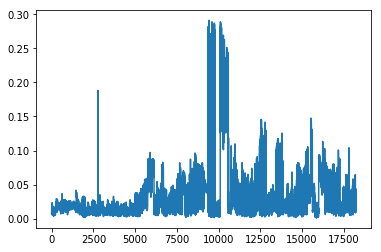

In [3]:
sample_trade_chances = vs_trade_chances[(vs_trade_chances.date >= '2015-01-01') & (vs_trade_chances.date <= '2015-05-31')]
print('median of expected return: %0.2f%%' % (sample_trade_chances['expected_return'].median()*100))
print('average of expected return: %0.2f%%' % (sample_trade_chances['expected_return'].mean()*100))
sample_trade_chances['expected_return'].plot()

## 曲面交易机会的收敛情况

计算持仓套利对在建仓后的5天内的收敛情况

In [32]:
trading_days = pd.read_csv('/Users/davidyujun/Dropbox/OptVolTrading/data/tradingdays.csv', header=0)
pre_trading_day = trading_days.iloc[0]['tradingday']
df_tradechance_convergence = DataFrame()
t = 0
for _, trade_chance in vs_trade_chances.head().iterrows():
    t +=1
    if t % 10000 == 0:
        print(t)
    trading_day = trade_chance['datetime'][:10]
    short_opt_code = trade_chance['short_opt_code']
    short_opt_vol = trade_chance['short_opt_volume']
    short_opt_cost = trade_chance['short_opt_price']
    long_opt_code = trade_chance['long_opt_code']
    long_opt_vol = trade_chance['long_opt_volume']
    long_opt_cost = trade_chance['long_opt_price']
    profit_spread = trade_chance['profit_spread']
    if trading_day != pre_trading_day:
        holding_days = trading_days[trading_days.tradingday >= trading_day].head(6)
        pre_trading_day = trading_day
    ser_tradechance_convergence = Series()
    k = 0
    for holding_day in list(holding_days['tradingday']):
        opt_quote_path = '/Users/davidyujun/Dropbox/opt_quote/%s/50OptionDailyQuote.csv' % holding_day
        df_opt_quote = pd.read_csv(opt_quote_path, header=0, dtype={'option_code': str}, encoding='GB2312')
        df_opt_quote.set_index('option_code', inplace=True)
        if short_opt_code not in df_opt_quote.index:
            print(short_opt_code, ' not at day: ', holding_day)
            ser_tradechance_convergence = Series()
            break
        if long_opt_code not in df_opt_quote.index:
            print(long_opt_code, ' not at day: ', holding_day)
            ser_tradechance_convergence = Series()
            break
        short_opt_close = df_opt_quote.loc[short_opt_code, 'close']
        long_opt_close = df_opt_quote.loc[long_opt_code, 'close']
        realized_profit_amount = (short_opt_vol * (short_opt_cost - short_opt_close) + long_opt_vol * (long_opt_close - long_opt_cost)) * 10000
        realized_profit_ratio = round(realized_profit_amount / profit_spread, 4)
        day_label = 'day' + str(k)
        ser_tradechance_convergence[day_label] = realized_profit_ratio
        k += 1
    if len(ser_tradechance_convergence) > 0:
        df_tradechance_convergence = df_tradechance_convergence.append(ser_tradechance_convergence, ignore_index=True)
# df_tradechance_convergence.to_csv('/Users/davidyujun/Dropbox/OptVolTrading/data/trade_chance_convergence.csv', index=False)
df_tradechance_convergence

,day0,day1,day2,day3,day4,day5
0,4.6024,6.8071,9.1526,13.1191,14.2553,14.4847
1,0.4566,0.4376,0.0571,-0.0846,0.1078,0.9344
2,3.1563,6.3482,8.8625,14.1229,14.4796,14.4439
3,0.4537,0.4348,0.0567,-0.0840,0.1071,0.9283
4,2.3561,3.1171,3.8316,5.9135,5.8247,5.9831


In [43]:
tradechance_convergency_path = '/Users/davidyujun/Dropbox/OptVolTrading/data/trade_chance_convergence.csv'
df_tradechance_convergence = pd.read_csv(tradechance_convergency_path,usecols=range(3,9),header=0)
print(df_tradechance_convergence.head())
df_tradechance_convergence.mean()

     day0    day1    day2     day3     day4     day5
0  4.6024  6.8071  9.1526  13.1191  14.2553  14.4847
1  0.4566  0.4376  0.0571  -0.0846   0.1078   0.9344
2  3.1563  6.3482  8.8625  14.1229  14.4796  14.4439
3  0.4537  0.4348  0.0567  -0.0840   0.1071   0.9283
4  2.3561  3.1171  3.8316   5.9135   5.8247   5.9831


day0    0.112597
day1    0.146459
day2    0.092686
day3    0.070932
day4    0.055679
day5    0.088515
dtype: float64